# Text Clustering & Topic Modeling of Pathway Student Questions

This notebook demonstrates how to cluster and explore **student questions** using modern NLP techniques, including embeddings, dimensionality reduction, clustering, and topic modeling.

---

---

This notebook demonstrates clustering and topic modeling for **student questions** using:
- Embeddings
- Dimensionality reduction
- Clustering
- Topic modeling

The workflow is designed for educational data analysis and visualization.

---

> **Note:** Unlike the original notebook (which used arXiv paper titles and abstracts), this workflow uses a custom dataset of student questions stored in a `.txt` file.

### Workflow Steps

1. Convert questions into embedding vectors
2. Reduce embeddings to 5 dimensions
3. Cluster the reduced embeddings
4. Generate keyword-based topics
5. Reduce embeddings to 2 dimensions for visualization
6. Visualize questions and topics
7. Use OpenAI to generate short topic labels

## Setup & Install Dependencies

In [1]:
# Dependencies are installed via requirements.txt
# Run: pip install -r requirements.txt
# Or use: make install

print("✅ Dependencies should be installed via requirements.txt")
print("If you haven't installed them yet, run:")
print("  pip install -r requirements.txt")
print("  or")  
print("  make install")

✅ Dependencies should be installed via requirements.txt
If you haven't installed them yet, run:
  pip install -r requirements.txt
  or
  make install


## Load Dataset

Use the file upload method to flexibly and reliably select the latest dataset of student questions from your computer. This avoids hardcoding file paths or filenames.

In [2]:
import os
from pathlib import Path
from ipyfilechooser import FileChooser

# Create file chooser widget for selecting the dataset
print("📁 Select your questions dataset file:")
print("Expected format: extracted_user_inputs_<date>.txt")

# Set up file chooser to look in data directory by default
data_dir = Path("data")
if not data_dir.exists():
    data_dir.mkdir(exist_ok=True)

fc = FileChooser(
    path=str(data_dir),
    filename='',
    title='Select Questions Dataset File',
    select_desc='Select',
    change_desc='Change'
)

# Display the file chooser
fc

📁 Select your questions dataset file:
Expected format: extracted_user_inputs_<date>.txt


FileChooser(path='/home/chrisflex/byu-pathway/pathway-questions-topic-modelling/data', filename='', title='Sel…

In [4]:
# Load questions from the selected file
# For testing, we'll use the sample file if no file is selected
import os
from pathlib import Path

if 'fc' in locals() and fc.selected:
    filename = fc.selected
    print(f"📄 Loading file: {filename}")
else:
    # Use sample data for testing
    sample_file = Path("data/sample_questions.txt")
    if sample_file.exists():
        filename = str(sample_file)
        print(f"📄 Using sample data file: {filename}")
    else:
        print("❌ No file selected and no sample file found.")
        print("Please run the cell above and select a file, or create a sample file.")
        questions = []

if 'filename' in locals() and filename:
    try:
        # Load questions from the selected file
        with open(filename, "r", encoding="utf-8") as f:
            questions = [line.strip() for line in f if line.strip()]
        
        print(f"✅ Loaded {len(questions)} questions")
        print("Sample questions:")
        for i, q in enumerate(questions[:5], 1):
            print(f"{i}. {q}")
            
        if len(questions) == 0:
            print("⚠️ Warning: No questions found in the file!")
        elif len(questions) < 10:
            print("⚠️ Warning: Very few questions found. Consider adding more data for better clustering.")
        else:
            print(f"✅ Good dataset size for analysis")
            
    except Exception as e:
        print(f"❌ Error loading file: {e}")
        questions = []
else:
    questions = []

📄 Using sample data file: data/sample_questions.txt
✅ Loaded 50 questions
Sample questions:
1. How do I register for English Connect classes?
2. What are the requirements to join BYU Pathway Connect?
3. How can I apply for financial aid for my courses?
4. When does the next semester start for PathwayConnect?
5. What technical requirements do I need for online classes?
✅ Good dataset size for analysis


## Create Embeddings
We will use a **sentence transformer** to embed each question into a high-dimensional vector

In [5]:
from openai import OpenAI
import numpy as np
import os
from dotenv import load_dotenv
from tqdm.auto import tqdm

# Load environment variables from .env file
load_dotenv()

# Get OpenAI API key from environment
api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    raise ValueError(
        "❌ OPENAI_API_KEY not found in environment variables.\n"
        "Please create a .env file with your OpenAI API key:\n"
        "OPENAI_API_KEY=your_key_here\n"
        "Or run: make create-env"
    )

print("✅ OpenAI API key loaded successfully")
client = OpenAI(api_key=api_key)

# Function to generate embeddings in batches
def generate_embeddings_in_batches(client, questions, model="text-embedding-3-large", batch_size=1000):
    """
    Generate embeddings for questions in batches to handle API rate limits.
    
    Args:
        client: OpenAI client instance
        questions: List of question strings
        model: Embedding model to use
        batch_size: Number of questions to process per batch
    
    Returns:
        numpy array of embeddings
    """
    if not questions:
        print("❌ No questions provided")
        return np.array([])
        
    print(f"🔄 Generating embeddings for {len(questions)} questions using {model}")
    print(f"Processing in batches of {batch_size}")
    
    embeddings = []
    failed_batches = []
    
    for i in tqdm(range(0, len(questions), batch_size)):
        batch = questions[i : i + batch_size]
        batch_num = i // batch_size + 1
        
        try:
            response = client.embeddings.create(
                model=model,
                input=batch
            )
            batch_embeddings = [d.embedding for d in response.data]
            embeddings.extend(batch_embeddings)
            
            # Progress update
            if batch_num % 5 == 0:
                print(f"✅ Processed batch {batch_num}/{(len(questions)-1)//batch_size + 1}")
                
        except Exception as e:
            print(f"❌ Error processing batch {batch_num}: {e}")
            failed_batches.append(batch_num)
            # Add empty embeddings for failed batch to maintain alignment
            # In production, you might want to retry or handle this differently
            continue
    
    if failed_batches:
        print(f"⚠️ Failed to process {len(failed_batches)} batches: {failed_batches}")
    
    embeddings_array = np.array(embeddings)
    print(f"✅ Generated {len(embeddings_array)} embeddings with shape {embeddings_array.shape}")
    
    return embeddings_array

# Check if we have questions to process
if 'questions' not in locals() or len(questions) == 0:
    print("❌ No questions found. Please run the file selection cells above first.")
    embeddings = np.array([])
else:
    # Generate embeddings with OpenAI
    embedding_model = os.getenv('OPENAI_EMBEDDING_MODEL', 'text-embedding-3-large')
    embeddings = generate_embeddings_in_batches(client, questions, model=embedding_model)

# Display embedding info
if len(embeddings) > 0:
    print(f"📊 Embedding dimensions: {embeddings.shape}")
    print(f"📊 Memory usage: {embeddings.nbytes / 1024 / 1024:.2f} MB")
else:
    print("❌ No embeddings generated")

✅ OpenAI API key loaded successfully
🔄 Generating embeddings for 50 questions using text-embedding-3-large
Processing in batches of 1000


  0%|          | 0/1 [00:00<?, ?it/s]

✅ Generated 50 embeddings with shape (50, 3072)
📊 Embedding dimensions: (50, 3072)
📊 Memory usage: 1.17 MB


## Reduce embeddings to 5 dimensions (for clustering)

In [6]:
from umap import UMAP

# Reduce from 3072 → 5 dims
umap_model = UMAP(
    n_components=5,
    min_dist=0.0,
    metric='cosine',
    random_state=42
)
reduced_embeddings = umap_model.fit_transform(embeddings)

/home/chrisflex/byu-pathway/pathway-questions-topic-modelling/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Cluster the reduced embeddings

In [7]:
from hdbscan import HDBSCAN

# Check if we have reduced embeddings
if 'reduced_embeddings' not in locals():
    print("❌ Reduced embeddings not found. Please run the UMAP reduction cell above first.")
else:
    print("🔄 Clustering the reduced embeddings...")
    
    # Cluster with HDBSCAN
    # Using smaller min_cluster_size as recommended by Dallan (5-10 instead of 50)
    min_cluster_size = 5  # Adjusted from 50 to 5 based on meeting feedback
    
    print(f"Using min_cluster_size={min_cluster_size} (reduced from 50 based on feedback)")
    
    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric="euclidean",
        cluster_selection_method="eom",
        prediction_data=True  # Allows for predicting cluster membership of new points
    )
    
    clusters = hdbscan_model.fit_predict(reduced_embeddings)
    
    # Analyze clustering results
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    n_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)  # Exclude noise cluster (-1)
    n_noise = counts[unique_clusters == -1][0] if -1 in unique_clusters else 0
    
    print(f"\n📊 Clustering Results:")
    print(f"   Total questions: {len(clusters)}")
    print(f"   Number of clusters: {n_clusters}")
    print(f"   Questions in noise (no cluster): {n_noise} ({n_noise/len(clusters)*100:.1f}%)")
    print(f"   Questions in clusters: {len(clusters) - n_noise} ({(len(clusters) - n_noise)/len(clusters)*100:.1f}%)")
    
    print(f"\n📈 Cluster sizes:")
    cluster_info = []
    for cluster_id, count in zip(unique_clusters, counts):
        if cluster_id != -1:  # Skip noise cluster
            cluster_info.append((cluster_id, count))
            print(f"   Cluster {cluster_id}: {count} questions")
    
    # Sort by size
    cluster_info.sort(key=lambda x: x[1], reverse=True)
    
    if n_noise > len(clusters) * 0.5:
        print(f"\n⚠️  High noise ratio ({n_noise/len(clusters)*100:.1f}%)")
        print("   Consider reducing min_cluster_size further or adjusting other parameters")
    elif n_clusters < 5:
        print(f"\n⚠️  Few clusters found ({n_clusters})")
        print("   Consider reducing min_cluster_size or adjusting other parameters")
    else:
        print(f"\n✅ Good clustering results: {n_clusters} clusters with reasonable noise level")
        
    # Store results for later use
    clustering_results = {
        'clusters': clusters,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'cluster_info': cluster_info
    }

🔄 Clustering the reduced embeddings...
Using min_cluster_size=5 (reduced from 50 based on feedback)

📊 Clustering Results:
   Total questions: 50
   Number of clusters: 3
   Questions in noise (no cluster): 13 (26.0%)
   Questions in clusters: 37 (74.0%)

📈 Cluster sizes:
   Cluster 0: 17 questions
   Cluster 1: 10 questions
   Cluster 2: 10 questions

⚠️  Few clusters found (3)
   Consider reducing min_cluster_size or adjusting other parameters


/home/chrisflex/byu-pathway/pathway-questions-topic-modelling/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chrisflex/byu-pathway/pathway-questions-topic-modelling/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Reduce to 2D for visualization

In [8]:
import pandas as pd

# Reduce again for visualization (3072 → 2)
reduced_2d = UMAP(
    n_components=2,
    min_dist=0.0,
    metric='cosine',
    random_state=42
).fit_transform(embeddings)

# Create dataframe
df = pd.DataFrame(reduced_2d, columns=["x", "y"])
df["questions"] = questions
df["cluster"] = clusters

/home/chrisflex/byu-pathway/pathway-questions-topic-modelling/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Visualize clusters

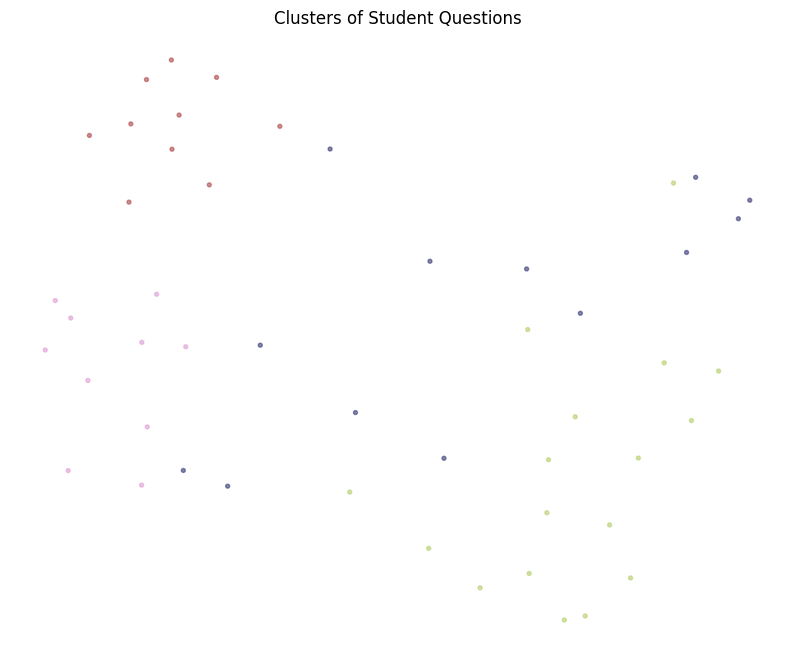

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
plt.scatter(df.x, df.y, c=df.cluster, cmap="tab20b", alpha=0.6, s=8)
plt.title("Clusters of Student Questions")
plt.axis("off")
plt.show()

## Fit BETTopic with your OpenAI embeddings

In [10]:
from bertopic import BERTopic

# Train our model with our previously defined models
topic_model = BERTopic(
    embedding_model=None, # We already have embeddings
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(questions, embeddings)

topic_model.get_topic_info().head(10)

2025-08-26 00:49:47,938 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-26 00:49:48,077 - BERTopic - Dimensionality - Completed ✓
2025-08-26 00:49:48,078 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-26 00:49:48,077 - BERTopic - Dimensionality - Completed ✓
2025-08-26 00:49:48,078 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-26 00:49:48,118 - BERTopic - Cluster - Completed ✓
2025-08-26 00:49:48,118 - BERTopic - Cluster - Completed ✓
2025-08-26 00:49:48,151 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-26 00:49:48,151 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-26 00:49:48,205 - BERTopic - Representation - Completed ✓
2025-08-26 00:49:48,205 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,13,-1_how_pathwayconnect_are_available,"[how, pathwayconnect, are, available, access, ...",[What career services are available to student...
1,0,17,0_for_aid_financial_what,"[for, aid, financial, what, students, how, are...",[What are the graduation requirements for my p...
2,1,10,1_english_connect_do_how,"[english, connect, do, how, know, register, fo...",[What materials do I need for English Connect ...
3,2,10,2_my_the_learning_online,"[my, the, learning, online, classes, need, for...",[What technical requirements do I need for onl...


## Use OpenAI to label topics

In [ ]:
from bertopic.representation import OpenAI

# Check if we have a fitted topic model
if 'topic_model' not in locals():
    print("❌ Topic model not found. Please run the BERTopic fitting cell above first.")
else:
    print("🔄 Using OpenAI to generate better topic labels...")
    
    # Enhanced prompt for educational context
    prompt = """
    I have a topic that contains the following questions:
    [DOCUMENTS]
    
    The topic is described by the following keywords: [KEYWORDS]
    
    Based on the questions above, create a short, clear topic label that describes what people are asking about.
    Focus on the main subject or concern in the questions.
    
    Format your response as:
    topic: <short descriptive label>
    """
    
    # Get the chat model from environment or use default
    chat_model = os.getenv('OPENAI_CHAT_MODEL', 'gpt-4o-mini')  # Fixed typo: was gpt_4o-mini
    print(f"Using model: {chat_model}")
    
    try:
        representation_model = OpenAI(
            client,
            model=chat_model,
            exponential_backoff=True,
            chat=True,
            prompt=prompt,
            delay_in_seconds=2  # Add delay to respect rate limits
        )
        
        print("🔄 Updating topic representations with OpenAI...")
        topic_model.update_topics(questions, representation_model=representation_model)
        
        # Display updated topic information
        topic_info = topic_model.get_topic_info().head(10)
        print("✅ Topics updated successfully!")
        print("\n📋 Top 10 Topics:")
        display(topic_info)
        
        # Save topic info for analysis
        print(f"\n📊 Total topics found: {len(topic_model.get_topic_info())}")
        
        # Show some examples of topic assignments
        print(f"\n🔍 Sample topic assignments:")
        for i in range(min(10, len(questions))):
            topic_id = topic_model.get_document_info(questions)['Topic'].iloc[i]
            if topic_id != -1:  # Skip noise
                topic_name = topic_model.get_topic_info().iloc[topic_id]['Name']
                print(f"   Q: {questions[i][:80]}...")
                print(f"   → Topic {topic_id}: {topic_name}")
                print()
            
    except Exception as e:
        print(f"❌ Error updating topics with OpenAI: {e}")
        print("Continuing with default keyword-based topic names...")
        topic_info = topic_model.get_topic_info().head(10)
        print("\n📋 Topics with keyword-based names:")
        display(topic_info)

🔄 Using OpenAI to generate better topic labels...
Using model: gpt-4o-mini
🔄 Updating topic representations with OpenAI...


100%|██████████| 4/4 [00:10<00:00,  2.75s/it]

✅ Topics updated successfully!

📋 Top 10 Topics:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,13,-1_BYU Pathway Services and Support,[BYU Pathway Services and Support],[What career services are available to student...
1,0,17,0_Financial Aid and Payment Plans,[Financial Aid and Payment Plans],[What are the graduation requirements for my p...
2,1,10,1_English Connect Registration and Information,[English Connect Registration and Information],[What materials do I need for English Connect ...
3,2,10,2_Technical Issues in Online Classes,[Technical Issues in Online Classes],[What technical requirements do I need for onl...



📊 Total topics found: 4

🔍 Sample topic assignments:
   Q: How do I register for English Connect classes?...
   → Topic 1: 0_Financial Aid and Payment Plans

   Q: How can I apply for financial aid for my courses?...
   → Topic 0: -1_BYU Pathway Services and Support

   Q: What technical requirements do I need for online classes?...
   → Topic 2: 1_English Connect Registration and Information

   Q: Can I transfer credits from other institutions?...
   → Topic 0: -1_BYU Pathway Services and Support

   Q: Can I transfer credits from other institutions?...
   → Topic 0: -1_BYU Pathway Services and Support

   Q: What support is available for students with disabilities?...
   → Topic 0: -1_BYU Pathway Services and Support

   Q: How do I contact my academic advisor?...
   → Topic 0: -1_BYU Pathway Services and Support

   Q: What are the costs associated with the program?...
   → Topic 0: -1_BYU Pathway Services and Support

   Q: What support is available for students with disabilities

## Visualizations

In [12]:
# Interactive doc visualization
fig = topic_model.visualize_documents(
    questions,
    reduced_embeddings=reduced_2d,
    width=1200,
    hide_annotations=True
)
fig.show()

# Keyword barchart
topic_model.visualize_barchart()

# Heatmap of topics
topic_model.visualize_heatmap

# Hierarchical topic structure
topic_model.visualize_hierarchy()

## Export Results to CSV

In [13]:
# Export results for stakeholder review
import pandas as pd
from datetime import datetime

print("📊 Preparing results for export...")

# Create comprehensive results dataframe
if 'topic_model' in locals():
    # Get document info from BERTopic
    doc_info = topic_model.get_document_info(questions)
    
    # Create results dataframe with all relevant information
    results_df = pd.DataFrame({
        'Question': questions,
        'Topic_ID': doc_info['Topic'].values,
        'Topic_Name': [topic_model.get_topic_info().iloc[topic_id]['Name'] if topic_id != -1 
                      else 'Uncategorized' for topic_id in doc_info['Topic'].values],
        'Probability': doc_info['Probability'].values,
        'Cluster': clusters if 'clusters' in locals() else doc_info['Topic'].values,
        'Representative_Doc': doc_info['Representative_document'].values
    })
    
    # Add timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    
    # Export to CSV
    csv_filename = f"results/pathway_questions_analysis_{timestamp}.csv"
    
    # Create results directory if it doesn't exist
    import os
    os.makedirs("results", exist_ok=True)
    
    # Save the file
    results_df.to_csv(csv_filename, index=False, encoding='utf-8')
    
    print(f"✅ Results exported to: {csv_filename}")
    print(f"📋 Total questions analyzed: {len(results_df)}")
    print(f"📊 Topics found: {len(topic_model.get_topic_info()) - 1}")  # Exclude -1 topic
    
    # Show summary by topic
    print(f"\n📈 Questions per topic:")
    topic_summary = results_df.groupby(['Topic_ID', 'Topic_Name']).size().reset_index(name='Count')
    topic_summary = topic_summary.sort_values('Count', ascending=False)
    
    for _, row in topic_summary.iterrows():
        print(f"   Topic {row['Topic_ID']}: {row['Topic_Name']} ({row['Count']} questions)")
        
    # Display first few rows
    print(f"\n📄 Sample of exported data:")
    display(results_df.head())
    
else:
    print("❌ Topic model not found. Please run the BERTopic cells first.")

📊 Preparing results for export...
✅ Results exported to: results/pathway_questions_analysis_20250826_0102.csv
📋 Total questions analyzed: 50
📊 Topics found: 3

📈 Questions per topic:
   Topic 0: -1_BYU Pathway Services and Support (17 questions)
   Topic -1: Uncategorized (13 questions)
   Topic 1: 0_Financial Aid and Payment Plans (10 questions)
   Topic 2: 1_English Connect Registration and Information (10 questions)

📄 Sample of exported data:


,Question,Topic_ID,Topic_Name,Probability,Cluster,Representative_Doc
0,How do I register for English Connect classes?,1,0_Financial Aid and Payment Plans,1.000000,1,True
1,What are the requirements to join BYU Pathway ...,-1,Uncategorized,0.000000,-1,False
2,How can I apply for financial aid for my courses?,0,-1_BYU Pathway Services and Support,1.000000,0,True
3,When does the next semester start for PathwayC...,-1,Uncategorized,0.000000,-1,False
4,What technical requirements do I need for onli...,2,1_English Connect Registration and Information,0.894632,2,True
